This project uses the famous MNIST dataset.
First, we'll import MNIST from the csv file.

In [110]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')

Let's look at some of the data and how it is stored:

In [111]:
#data[0] #this stopped working suddenly at 11:27... if it works I will add back in

As can be seen, the file contains grey-scale images of hand-written digits, from 0 to 9, and the grey-scale values are between 0 (black) and 255 (white). There are 784 columns that will be used as the input layer. 

The goal is to predict the digit of an image, using a 2-layer Neural Network.

In [112]:
data = np.array(data) #changing to np array from pandas dataframe

np.random.shuffle(data)

data_original = data[0:1000].T #copy of first 1000 samples of original data 
Y_original = data_original[0] #first row which contains labels(was first column)
#m = 42000
#n=785
X_original = data_original[1:785] #everything else
X_original = X_original/255.

data_train = data[1000:42000].T #data we're actually training on
Y_train = data_train[0]
X_train = data_train[1:785]
X_train = X_train/255 #normalizing X_train
_, m_train = X_train.shape

#X_train[:, 0].shape just to look #our first column has 784 pixels in it

In [113]:
def init_params():
    weight_1 = np.random.rand(256, 784) - 0.5 #creates random values between -0.5 and 0.5
    weight_2 = np.random.rand(128, 256) - 0.5
    weight_3 = np.random.rand(64, 128) - 0.5
    weight_4 = np.random.rand(10,64) - 0.5

    bias_1 = np.random.rand(256, 1) - 0.5
    bias_2 = np.random.rand(128, 1) - 0.5
    bias_3 = np.random.rand(64,1) - 0.5
    bias_4 = np.random.rand(10,1) - 0.5
    return weight_1, bias_1, weight_2, bias_2, weight_3, bias_3, weight_4, bias_4

def LinearUnit(Z): #linear function
    return np.maximum(Z, 0)

def softmax(Z): #we want the sum for each column across all of the rows in that column, then divide each element of that sum
    A = np.exp(Z) / sum(np.exp(Z)) #preserves amount of columns and colapses amount of rows
    #formula: e^Z_i/summation(e^Z_j)
    return A
    


Forward propagation is how you get a prediction from an image...

In [114]:
def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    Z1 = W1.dot(X) + b1
    A1 = LinearUnit(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = LinearUnit(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = LinearUnit(Z3)
    Z4 = W4.dot(A3) + b4
    A4 = softmax(Z4)
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

def LinearUnit_deriv(Z):
    return (Z > 0) #slope of linear equation is 0 and then 1, so return 1 if greater than 0

def one_hot(Y):
    size = Y.size
    output_classes = Y.max() + 1
    OH_Y = np.zeros((size, output_classes))
    OH_Y[np.arange(size), Y] = 1 #goes through each row and at the desired column sets the value to 1
    OH_Y = OH_Y.T #flip to make each column each example
    return OH_Y

Backward propagation starts with the predication, and calculates how much the predication differentiates from the actual label.

In [115]:

def backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y):
    OH_Y = one_hot(Y)
    #Formula: dz_n = A_n-Y
    dZ4 = A4- OH_Y
    dW4 = 1 / 42000 * dZ4.dot(A3.T)
    db4 = 1 / 42000 * np.sum(dZ4)
    dZ3 = W4.T.dot(dZ4) * LinearUnit_deriv(Z3)
    dW3 = 1 / 42000 * dZ3.dot(A2.T)
    db3 = 1 / 42000 * np.sum(dZ3)
    dZ2 = W3.T.dot(dZ3) * LinearUnit_deriv(Z2)
    dW2 = 1 / 42000 * dZ2.dot(A1.T)
    db2 = 1 / 42000 * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * LinearUnit_deriv(Z1)
    dW1 = 1 / 42000 * dZ1.dot(X.T)
    db1 = 1 / 42000 * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, a):
    W1 = W1 - a * dW1
    b1 = b1 - a * db1    
    W2 = W2 - a * dW2  
    b2 = b2 - a * db2
    W3 = W3 - a * dW3
    b3 = b3 - a * db3    
    W4 = W4 - a * dW4  
    b4 = b4 - a * db4
    return W1, b1, W2, b2, W3, b3, W4, b4

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(pred, Y):
    print(pred, Y)
    return np.sum(pred == Y) / Y.size

Now we have everything we need to execute the gradient descent on the neural network...

In [117]:
def gradient_descent(X, Y, a, j):
    W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
    for i in range(j):
        #forward prop first
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
        #next back prop using first prop
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = backward_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y)
        #update weights using backward prop
        W1, b1, W2, b2, W3, b3, W4, b4 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, a)
        if i % 10 == 0:
            predictions = get_predictions(A4)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2, W3, b3, W4, b4

W1, b1, W2, b2, W3, b3, W4, b4 = gradient_descent(X_train, Y_train, 0.1, 500)


[9 9 9 ... 9 7 9] [2 2 9 ... 8 3 0]
0.11736585365853658
[0 2 0 ... 0 0 2] [2 2 9 ... 8 3 0]
0.09804878048780488
[0 2 0 ... 0 0 2] [2 2 9 ... 8 3 0]
0.10492682926829268
[0 2 0 ... 0 0 2] [2 2 9 ... 8 3 0]
0.11339024390243903
[0 2 0 ... 0 0 2] [2 2 9 ... 8 3 0]
0.12419512195121951
[0 2 0 ... 0 0 0] [2 2 9 ... 8 3 0]
0.1395609756097561
[0 2 0 ... 0 0 0] [2 2 9 ... 8 3 0]
0.1561219512195122
[5 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.174
[5 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.19426829268292684
[5 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.21204878048780487
[8 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.231
[8 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.24958536585365854
[8 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.26690243902439026
[2 2 0 ... 5 0 0] [2 2 9 ... 8 3 0]
0.2837073170731707
[2 2 0 ... 8 0 0] [2 2 9 ... 8 3 0]
0.29860975609756096
[2 2 0 ... 8 0 0] [2 2 9 ... 8 3 0]
0.3128292682926829
[2 2 0 ... 8 0 0] [2 2 9 ... 8 3 0]
0.32490243902439025
[2 2 0 ... 8 0 0] [2 2 9 ... 8 3 0]
0.3362926829268293
[2 2 0 ... 5 0 0] [2 2 9 

Adding more layers would give higher accuracy. 

In [122]:
def make_predictions(X,W1, b1, W2, b2, W3, b3, W4, b4):
    _, _, _, _, _, _, _, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
    print("A4", A4)
    predictions = get_predictions(A4)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4):
    image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3, W4, b4)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    image = image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()



Examples of predicting 5 and the label it guesses. If you want to try more numbers, just change the first parameter to whatever number between 0 and 9.

A4 [[0.04848731]
 [0.00047176]
 [0.02054154]
 [0.17280496]
 [0.15447954]
 [0.37126558]
 [0.048607  ]
 [0.02195988]
 [0.14923594]
 [0.01214649]]
Prediction:  [5]
Label:  5


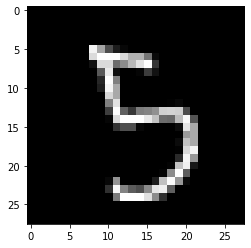

A4 [[7.35506481e-04]
 [3.74417244e-47]
 [9.81655629e-01]
 [6.75823611e-03]
 [4.82276479e-10]
 [1.06499074e-02]
 [7.21084578e-05]
 [8.21839078e-09]
 [1.28603789e-04]
 [2.21462219e-11]]
Prediction:  [2]
Label:  2


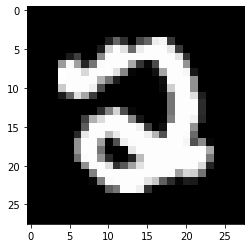

In [123]:
test_prediction(5, W1, b1, W2, b2, W3, b3, W4, b4)
test_prediction(1, W1, b1, W2, b2, W3, b3, W4, b4)


An example of a failed prediction is a number like 149:

A4 [[2.94636242e-05]
 [1.91584616e-08]
 [1.50547332e-03]
 [1.57457766e-03]
 [5.12993060e-05]
 [7.59025624e-05]
 [5.81998165e-06]
 [9.94283793e-01]
 [3.04094564e-04]
 [2.16955693e-03]]
Prediction:  [7]
Label:  7


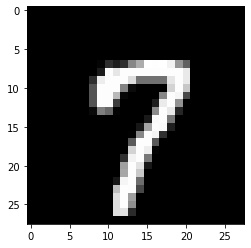

In [120]:
test_prediction(149, W1, b1, W2, b2, W3, b3, W4, b4)


Let's cross-validate the accuracy with the original data:

In [121]:
original_predictions = make_predictions(X_original, W1, b1, W2, b2, W3, b3, W4, b4)
get_accuracy(original_predictions, Y_original)


A4 [[9.64327778e-02 9.46701584e-06 7.99152166e-05 ... 4.49713728e-06
  3.85210826e-01 4.57077717e-08]
 [7.00153458e-12 9.77015318e-01 5.83953752e-10 ... 1.06716199e-09
  1.55790313e-38 2.85217882e-05]
 [2.71315751e-03 9.21874062e-03 4.36415915e-04 ... 1.81299698e-03
  5.20763711e-01 3.39023444e-02]
 ...
 [3.30386213e-03 1.08547469e-02 5.48926426e-03 ... 9.96047183e-01
  1.10402060e-07 1.33797916e-05]
 [1.05692600e-02 1.52429955e-04 3.13315698e-03 ... 2.58366329e-04
  2.00138360e-02 7.08799183e-01]
 [6.39583859e-05 5.32669277e-05 2.43285896e-01 ... 1.37769508e-03
  7.55016927e-11 4.70477782e-05]]
[5 1 4 6 4 4 3 1 5 0 2 4 8 4 0 1 7 7 8 1 4 9 1 9 6 9 8 8 0 6 3 8 4 8 5 1 4
 5 5 6 0 7 3 0 8 9 1 0 2 1 0 4 0 7 1 4 7 2 3 9 4 8 5 5 0 6 0 2 1 4 1 5 3 6
 5 6 1 6 7 0 8 4 8 0 9 1 5 4 7 7 0 7 2 6 3 6 8 0 8 3 7 8 3 1 3 5 4 1 1 2 4
 4 0 0 3 0 7 8 1 3 4 1 6 0 4 5 6 8 8 9 2 2 1 5 5 8 1 4 3 0 0 9 9 0 3 1 3 3
 6 4 4 1 7 3 7 6 6 1 4 8 8 8 9 7 1 6 4 2 6 1 4 8 6 0 6 0 4 4 7 1 2 9 1 1 8
 8 7 5 5 6 0 5 3 4 5 4

0.819